# DSCI 592: Data Science Capstone II <br> Wildfire By-Pixel Object Detection - From-Scratch UNET Model

## Model Objective
1. Ability to receive still images / video footage from UAV (Unmanned Aerial Vehicle)
2. Ability to process still images / video footage for modeling
3. Ability to detect forest fire on a by-pixel level (giving us the size and shape)

## Dataset(s) Used
1. FLAME 1 Dataset - "FIRE BOUNDARY DATASET"
    - Consists of RGB .jpg and image mask pairs
    - 2,003 image pairs in total
    - Images initially sized 2,160 x 3,840

## Import Relevant libraries

First, we will import the libraries needed for our model development. These will be broken up by their uses.

In [1]:
#Importing and reading images
from pathlib import Path
import cv2
import os
import re
from PIL import Image
from tqdm import tqdm

#General Utility
import random
import pandas as pd
import numpy as np

#Modeling - General
import pickle
import tensorflow as tf
from tensorflow.keras.models import Model

#Modeling - Layers
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose

#Modeling - Analysis / Evaluation
from tensorflow.keras.models import load_model
from skimage.io import imshow
import matplotlib.pyplot as plt

## Import and Prepare Dataset

In [2]:
### Global Variable Setting ###

#Directory paths:
dir_images = "C:\\Users\\ConnorRoth\\Documents\\Grad School\\Summer 2023\\DSCI 592\\Datasets\\FLAME 1\\Images"
dir_masks = "C:\\Users\\ConnorRoth\\Documents\\Grad School\\Summer 2023\\DSCI 592\\Datasets\\FLAME 1\\Masks"

#Image Sizing data:
img_size = (512, 512)
img_width = 512
img_height = 512
img_channels = 3

#Training data:
batch_size = 16
epochs = 30
num_classes = 2

In [3]:
### Establishing Paths ###

#Establish paths to images
allfiles_image = sorted(
    [
        os.path.join(dir_images, fname)
        for fname in tqdm(os.listdir(dir_images))
        if fname.endswith(".jpg")
    ]
)

#Establish paths for masks
allfiles_mask = sorted(
    [
        os.path.join(dir_masks, fname)
        for fname in tqdm(os.listdir(dir_masks))
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

100%|██████████| 2003/2003 [00:00<00:00, 334668.80it/s]


In [4]:
#Get total number of samples
total_samples = len(allfiles_mask)

#Establish split (80% Test, 10% Val, 10% Test)
val_samples_start = int(total_samples * (0.8))
test_samples_start = int(total_samples * (0.9))

#Shuffle images (but replicable)
random.Random(1337).shuffle(allfiles_image)
random.Random(1337).shuffle(allfiles_mask)

In [5]:
#Set paths - TRAIN
train_img_paths = allfiles_image[:val_samples_start]
train_mask_paths = allfiles_mask[:val_samples_start]

#Set paths - VAL
val_img_paths = allfiles_image[val_samples_start:test_samples_start]
val_mask_paths = allfiles_mask[val_samples_start:test_samples_start]

#Set paths - TEST
test_img_paths = allfiles_image[test_samples_start:]
test_mask_paths = allfiles_mask[test_samples_start:]

In [6]:
### TRAINING ###
x_train = np.zeros((len(train_img_paths), img_height, img_width, img_channels), dtype=np.uint8)
y_train = np.zeros((len(train_mask_paths), img_height, img_width, 1), dtype=bool)

#LOAD - Training Images
for n, file_ in tqdm(enumerate(train_img_paths)):
    img = tf.keras.preprocessing.image.load_img(file_, target_size=img_size)
    x_train[n] = img

#LOAD - Training Masks
for n, file_ in tqdm(enumerate(train_mask_paths)):
    img = tf.keras.preprocessing.image.load_img(file_, target_size=img_size, color_mode="grayscale")
    y_train[n] = np.expand_dims(img, axis=2)

1602it [02:40,  9.97it/s]
1602it [00:22, 70.29it/s]


In [7]:
### VALIDATION ###
x_val = np.zeros((len(val_img_paths), img_height, img_width, img_channels), dtype=np.uint8)
y_val = np.zeros((len(val_mask_paths), img_height, img_width, 1), dtype=bool)

#LOAD - Validation Images
for n, file_ in tqdm(enumerate(val_img_paths)):
    img = tf.keras.preprocessing.image.load_img(file_, target_size=img_size)
    x_val[n] = img

#LOAD - Validation Masks
for n, file_ in tqdm(enumerate(val_mask_paths)):
    img = tf.keras.preprocessing.image.load_img(file_, target_size=img_size, color_mode="grayscale")
    y_val[n] = np.expand_dims(img, axis=-1)

200it [00:19, 10.46it/s]
200it [00:02, 69.77it/s]


In [8]:
### TEST ###
x_test = np.zeros((len(test_img_paths), img_height, img_width, img_channels), dtype=np.uint8)
y_test = np.zeros((len(test_mask_paths), img_height, img_width, 1), dtype=bool)

#LOAD - Test Images
for n, file_ in tqdm(enumerate(test_img_paths)):
    img = tf.keras.preprocessing.image.load_img(file_, target_size=img_size)
    x_test[n] = img

#LOAD - Test Masks
for n, file_ in tqdm(enumerate(test_mask_paths)):
    img = tf.keras.preprocessing.image.load_img(file_, target_size=img_size, color_mode="grayscale")
    y_test[n] = np.expand_dims(img, axis=-1)

201it [00:19, 10.49it/s]
201it [00:02, 70.30it/s]


## Establishing Model Architecture

The model we are creating is based off this paper, a DCNN for medical image segmentation: https://arxiv.org/abs/1505.04597.

Specifically, a similar implementation has already been completed in the following paper: https://www.sciencedirect.com/science/article/pii/S1389128621001201?ref=cra_js_challenge&fr=RR-1.

In [9]:
def make_unet_model(img_height, img_width, img_channel, num_classes):
    inputs = Input((img_height, img_width, img_channel))
    s = Lambda(lambda x: x / 255)(inputs)

    #Block 1 - Contracting
    contract1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(s)
    contract1 = Dropout(0.1)(contract1)
    contract1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(contract1)
    pool1 = MaxPooling2D((2, 2))(contract1)

    #Block 2 - Contracting
    contract2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(pool1)
    contract2 = Dropout(0.1)(contract2)
    contract2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(contract2)
    pool2 = MaxPooling2D((2, 2))(contract2)

    #Block 3 - Contracting
    contract3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(pool2)
    contract3 = Dropout(0.2)(contract3)
    contract3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(contract3)
    pool3 = MaxPooling2D((2, 2))(contract3)

    #Block 4 - Contracting
    contract4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(pool3)
    contract4 = Dropout(0.2)(contract4)
    contract4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(contract4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(contract4)

    #Block 5 - Bottleneck Block
    bot5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(pool4)
    bot5 = Dropout(0.3)(bot5)
    bot5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(bot5)

    #Block 6 - Upsample (Block 5 x Block 4)
    upsample6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bot5)
    upsample6 = concatenate([upsample6, contract4])
    conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(upsample6)
    conv6 = Dropout(0.2)(conv6)
    conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv6)

    #Block 7 - Upsample (Block 6 x Block 3)
    upsample7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    upsample7 = concatenate([upsample7, contract3])
    block7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(upsample7)
    block7 = Dropout(0.2)(block7)
    block7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(block7)

    #Block 8 - Upsample (Block 7 x Block 2)
    upsample8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(block7)
    upsample8 = concatenate([upsample8, contract2])
    block8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(upsample8)
    block8 = Dropout(0.1)(block8)
    block8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(block8)

    #Block 9 - Upsample (Block 8 x Block 1)
    upsample9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(block8)
    upsample9 = concatenate([upsample9, contract1], axis=3)
    block9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(upsample9)
    block9 = Dropout(0.1)(block9)
    block9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(block9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(block9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [10]:
def model_unet_kaggle(img_hieght, img_width, img_channel, num_classes):
    """
    This function returns a U-Net Model for this binary fire segmentation images:
    Arxiv Link for U-Net: https://arxiv.org/abs/1505.04597
    :param img_hieght: Image Height
    :param img_width: Image Width
    :param img_channel: Number of channels in each image
    :param num_classes: Number of classes based on the Ground Truth Masks
    :return: A convolutional NN based on Tensorflow and Keras
    """
    inputs = Input((img_hieght, img_width, img_channel))
    s = Lambda(lambda x: x / 255)(inputs)

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

## Compiling & Training Model

In [11]:
METRICS = [
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.FalseNegatives(name='fn'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.BinaryIoU(name='IoU'),
    tf.keras.metrics.BinaryAccuracy(name='bin_accuracy')
]

In [12]:
#Call model construction
#unet_model = make_unet_model(img_height, img_width, img_channels, num_classes)
unet_model = model_unet_kaggle(img_height, img_width, img_channels, num_classes)

#Compile model
unet_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=METRICS)

#Set up model checkpoints and early stopping
checkpoint = tf.keras.callbacks.ModelCheckpoint("checkpoint_object_detection_unet.h5", save_best_only=True)
early_stopper = tf.keras.callbacks.EarlyStopping(patience=5)

In [13]:
#Fit model to training dataset
fitted_unet_model = unet_model.fit(x_train, y_train, validation_data = (x_val, y_val), 
                                   epochs = epochs, batch_size = batch_size, callbacks = [early_stopper, checkpoint])

Epoch 1/30
101/101 [==============================] - 1200s 12s/step - loss: 0.0343 - auc: 0.7906 - tp: 675122.0000 - tn: 415565856.0000 - fp: 1911127.0000 - fn: 1802556.0000 - precision: 0.2610 - recall: 0.2725 - IoU: 0.5725 - bin_accuracy: 0.9912 - val_loss: 0.0152 - val_auc: 0.8776 - val_tp: 163821.0000 - val_tn: 52106948.0000 - val_fp: 19340.0000 - val_fn: 138691.0000 - val_precision: 0.8944 - val_recall: 0.5415 - val_IoU: 0.7530 - val_bin_accuracy: 0.9970
Epoch 2/30
101/101 [==============================] - 1179s 12s/step - loss: 0.0085 - auc: 0.9706 - tp: 1790216.0000 - tn: 417127104.0000 - fp: 349851.0000 - fn: 687462.0000 - precision: 0.8365 - recall: 0.7225 - IoU: 0.8153 - bin_accuracy: 0.9975 - val_loss: 0.0208 - val_auc: 0.8624 - val_tp: 152289.0000 - val_tn: 52113396.0000 - val_fp: 12892.0000 - val_fn: 150223.0000 - val_precision: 0.9220 - val_recall: 0.5034 - val_IoU: 0.7399 - val_bin_accuracy: 0.9969
Epoch 3/30
101/101 [==============================] - 1172s 12s/step - 

Epoch 19/30
101/101 [==============================] - 1185s 12s/step - loss: 0.0030 - auc: 0.9990 - tp: 2184400.0000 - tn: 417254304.0000 - fp: 222699.0000 - fn: 293278.0000 - precision: 0.9075 - recall: 0.8816 - IoU: 0.9038 - bin_accuracy: 0.9988 - val_loss: 0.0057 - val_auc: 0.9808 - val_tp: 245404.0000 - val_tn: 52103924.0000 - val_fp: 22363.0000 - val_fn: 57108.0000 - val_precision: 0.9165 - val_recall: 0.8112 - val_IoU: 0.8769 - val_bin_accuracy: 0.9985
Epoch 20/30
101/101 [==============================] - 1188s 12s/step - loss: 0.0030 - auc: 0.9989 - tp: 2181918.0000 - tn: 417253824.0000 - fp: 223153.0000 - fn: 295760.0000 - precision: 0.9072 - recall: 0.8806 - IoU: 0.9033 - bin_accuracy: 0.9988 - val_loss: 0.0048 - val_auc: 0.9881 - val_tp: 253430.0000 - val_tn: 52099752.0000 - val_fp: 26538.0000 - val_fn: 49082.0000 - val_precision: 0.9052 - val_recall: 0.8378 - val_IoU: 0.8844 - val_bin_accuracy: 0.9986
Epoch 21/30
101/101 [==============================] - 1187s 12s/step - 

In [14]:
#Save model
unet_model.save('model_fire_pixel_detection_unet_V2')

INFO:tensorflow:Assets written to: model_fire_pixel_detection_unet_V2\assets


INFO:tensorflow:Assets written to: model_fire_pixel_detection_unet_V2\assets


## Evaluating Results of Model on Test

In [ ]:
#Load model, if needed
##unet_model = tf.keras.models.load_model("model_fire_pixel_detection_unet")

In [15]:
### General Test Function Definition
def test_by_pixel_object_detection(x_test, y_test, model):
    results_eval = model.evaluate(x_test, y_test, batch_size = batch_size)

    for name, value in zip(model.metrics_names, results_eval):
        print(name, ': ', value)
    print()

    return results_eval

In [16]:
#Call function to test model
test_by_pixel_object_detection(x_test, y_test, unet_model)

13/13 [==============================] - 34s 3s/step - loss: 0.0033 - auc: 0.9934 - tp: 249275.0000 - tn: 52378656.0000 - fp: 21896.0000 - fn: 41119.0000 - precision: 0.9193 - recall: 0.8584 - IoU: 0.8985 - bin_accuracy: 0.9988
loss :  0.0032652246300131083
auc :  0.9934166073799133
tp :  249275.0
tn :  52378656.0
fp :  21896.0
fn :  41119.0
precision :  0.9192538857460022
recall :  0.8584027290344238
IoU :  0.8985073566436768
bin_accuracy :  0.9988040328025818



[0.0032652246300131083,
 0.9934166073799133,
 249275.0,
 52378656.0,
 21896.0,
 41119.0,
 0.9192538857460022,
 0.8584027290344238,
 0.8985073566436768,
 0.9988040328025818]

In [23]:
#Derive F1 Score
Precision = 0.9192538857460022
Recall = 0.8584027290344238
F1 = 2 * (Precision * Recall) / (Precision + Recall)
print("F1 : ", F1)

F1 :  0.8877868061119714


The binary accuracy and precision/recall are quite high for this model! The accuraccy is especially high, which leads us to investigate further. The IoU sheds light on this, as [it measures the overlap between the predicted and the actual object](https://encord.com/glossary/iou-definition/). Here, we see that the value is just under 0.89, meaning that the overlap is very high. So, we can definitively say that the model performs very well in this task.

In [20]:
#Create a test function to plot specific images
def plot_segmentation_test(x_test, y_test, y_pred, num_samples):
    #Establish figure size
    fig = plt.figure(figsize=(14, 12))
    
    #Iterate through samples
    for i in range(0, num_samples):
        
        #Create subplot for Base Image
        plt.subplot(3, num_samples, (0 * num_samples) + i + 1)
        ix_test = random.randint(0, len(y_pred) - 1)
        title = str(i+1)
        plt.title(title)
        imshow(x_test[ix_test])
        plt.axis('off')

        #Create subplot for GROUND TRUTH Mask
        plt.subplot(3, num_samples, (1 * num_samples) + i + 1)
        plt.imshow(np.squeeze(y_test[ix_test]))
        plt.title('GROUND TRUTH Mask')
        plt.axis('off')

        #Create subplot for PREDICTED Mask
        plt.subplot(3, num_samples, (2 * num_samples) + i + 1)
        plt.imshow(np.squeeze(y_pred[ix_test]))
        plt.title('PREDICTED Mask')
        plt.axis('off')g

7/7 [==============================] - 28s 4s/step


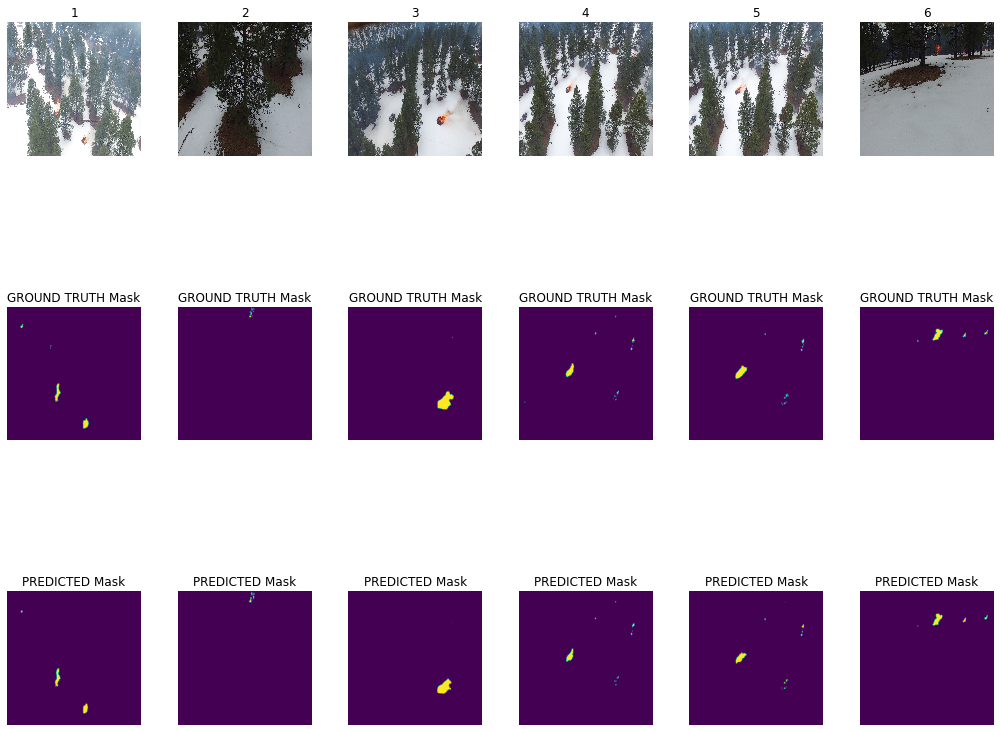

In [21]:
#Predict and create thresholds for X Test data
y_pred = unet_model.predict(x_test, verbose=1)
y_preds_t = (y_pred > 0.5).astype(np.uint8)

plot_segmentation_test(x_test = x_test, y_test = y_test, y_pred = y_preds_t, num_samples = 6)

We can see how closely - at an image level - the PREDICTED mask lines up with the GROUND TRUTH mask.